# Why Are Customers Churning?

#### Quick Reference

1. Project Plan
3. Imports
2. Acquire and Prep
3. EDA
4. Models
5. Model Evaluation
6. Conclusions

# Project Plan

**Summary**

The Senior Leading Team wants to find out why our customers are churning.

Below is a list of questions they would like answered:

1. Are there clear groupings where a customer is more likely to churn? What if you consider contract type? Is there a tenure that month-to-month customers are most likely to churn? 1-year contract customers? 2-year customers? Do you have any thoughts on what could be going on? (Be sure to state these thoughts not as facts but as untested hypotheses. Unless you test them!). Plot the rate of churn on a line chart where x is the tenure and y is the rate of churn (customers churned/total customers).
2. Are there features that indicate a higher propensity to churn? like type of Internet service, type of phone service, online security and backup, senior citizens, paying more than x% of customers with the same services, etc.?
3. Is there a price threshold for specific services where the likelihood of churn increases once price for those services goes past that point? If so, what is that point for what service(s)?
4. If we looked at churn rate for month-to-month customers after the 12th month and that of 1-year contract customers after the 12th month, are those rates comparable?

**Goals**
The goals of this project are to answer the above questions and to deliver our findings in the following formats:

1. Report with detailed analysis in .ipynb format
2. CSV file containing customer_id, probability of churn, and the prediction of churn (1=churn, 0=not_churn)
3. Google Slides explaining model chosen and brief analysis for SLT
4. All files necessary to recreate our findings and models
5. Readme file
6. GitHub repo containing all files

# Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

import acquire
import prepare
import encode
import explore

# Acquire and Prep

In [8]:
#bring in the data
telco = acquire.get_telco_data()

#Take a quick peek at Telco and look columns to see if we have any nulls and look at dtypes
telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
payment_type_id             7043 non-null int64
internet_service_type_id    7043 non-null int64
contract_type_id            7043 non-null int64
customer_id                 7043 non-null object
gender                      7043 non-null object
senior_citizen              7043 non-null int64
partner                     7043 non-null object
dependents                  7043 non-null object
tenure                      7043 non-null int64
phone_service               7043 non-null object
multiple_lines              7043 non-null object
online_security             7043 non-null object
online_backup               7043 non-null object
device_protection           7043 non-null object
tech_support                7043 non-null object
streaming_tv                7043 non-null object
streaming_movies            7043 non-null object
paperless_billing           7043 non-null object
monthly_charges 

- Surprisingly, it looks like we do not have any nulls within the data
- We can drop type id's, since they were only useful for merging

Fields to look at:
   * gender: Currently an object, likely needs to be encoded
   * senior_citizen: It's an int type, does that mean it's encoded already?
   * partner: I have no clue what this field is for
   * dependents: Currently an object, either it's a bool or should be an int identifying how many dependents
   * phone_service - paperless_billing: Needs to be encoded
   * total_charges: Definitely should not be an object, likely needs to be a float
   * churn: Probably needs to be encoded

In [9]:
#prep the data and split into train, test, and validate dataframes
train, test, validate = prepare.prep_telco(telco, .8, 123)

In [10]:
#encode some fields before EDA
#encoder_1 = encode_contract_types
#encoder_2 = encode_internet_service_types
#encoder_3 = encode_churn
#encoder_4 = encode_payment_types

encoder_1, encoder_2, encoder_3, encoder_4, train, test, validate = encode.encoded_df(train, test, validate)

In [16]:
#Ensure shaped off all splits look ok
print(train.shape, test.shape, validate.shape)

(4507, 26) (1409, 26) (1127, 26)


In [17]:
telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
payment_type_id             7043 non-null int64
internet_service_type_id    7043 non-null int64
contract_type_id            7043 non-null int64
customer_id                 7043 non-null object
gender                      7043 non-null object
senior_citizen              7043 non-null int64
partner                     7043 non-null object
dependents                  7043 non-null object
tenure                      7043 non-null int64
phone_service               7043 non-null object
multiple_lines              7043 non-null object
online_security             7043 non-null object
online_backup               7043 non-null object
device_protection           7043 non-null object
tech_support                7043 non-null object
streaming_tv                7043 non-null object
streaming_movies            7043 non-null object
paperless_billing           7043 non-null object
monthly_charges 

In [14]:
train.sample(4)

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,total_charges,churn,contract_type,internet_service_type,payment_type,tenure_years,contract_type_encoded,encoded_internet_service_type,churn_encoded,payment_type_encoded
4672,2252-JHJGE,Male,0,No,No,61,Yes,Yes,Yes,No,...,6363.45,No,One year,Fiber optic,Electronic check,5.0,1,1,0,2
4107,7821-DPRQE,Male,0,Yes,No,68,Yes,Yes,Yes,Yes,...,7320.90,No,Month-to-month,Fiber optic,Electronic check,6.0,0,1,0,2
6080,1269-FOYWN,Male,0,Yes,Yes,44,Yes,No,No internet service,No internet service,...,860.85,No,One year,None,Bank transfer (automatic),4.0,1,2,0,0
2513,0407-BDJKB,Male,0,Yes,No,60,Yes,Yes,No,Yes,...,5742.90,Yes,Month-to-month,Fiber optic,Electronic check,5.0,0,1,1,2


# Exploratory Data Analysis (EDA)

**Initial Hypothesis**: Customers who are month to month are most likely to churn

1. Create some features that encompass the consumer portions of our data, this will help us figure out **WHO** is churning
    - Gender
    - Senior or Not
    - Single household (dependents)
2. Run a Chi-Squared statistical test to see if there is a correlation between the above and churning
3. Take a look at all other components to look for the **DRIVERS** that are causing our customers to churn 

In [19]:
#take a look at stats info for numerical data
train.describe()

,senior_citizen,tenure,monthly_charges,total_charges,tenure_years,contract_type_encoded,encoded_internet_service_type,churn_encoded,payment_type_encoded
count,4507.000000,4507.000000,4507.000000,4507.000000,4507.000000,4507.000000,4507.000000,4507.000000,4507.000000
mean,0.165742,31.942978,64.791779,2256.158076,2.648325,0.686044,0.867318,0.266918,1.586421
std,0.371890,24.718649,29.886761,2263.086693,2.132100,0.833278,0.735363,0.442398,1.061271
min,0.000000,0.000000,18.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,8.000000,35.900000,374.250000,1.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,27.000000,70.300000,1387.450000,2.000000,0.000000,1.000000,0.000000,2.000000
75%,0.000000,55.000000,89.650000,3772.575000,5.000000,1.000000,1.000000,1.000000,2.000000
max,1.000000,72.000000,118.750000,8684.800000,6.000000,2.000000,2.000000,1.000000,3.000000


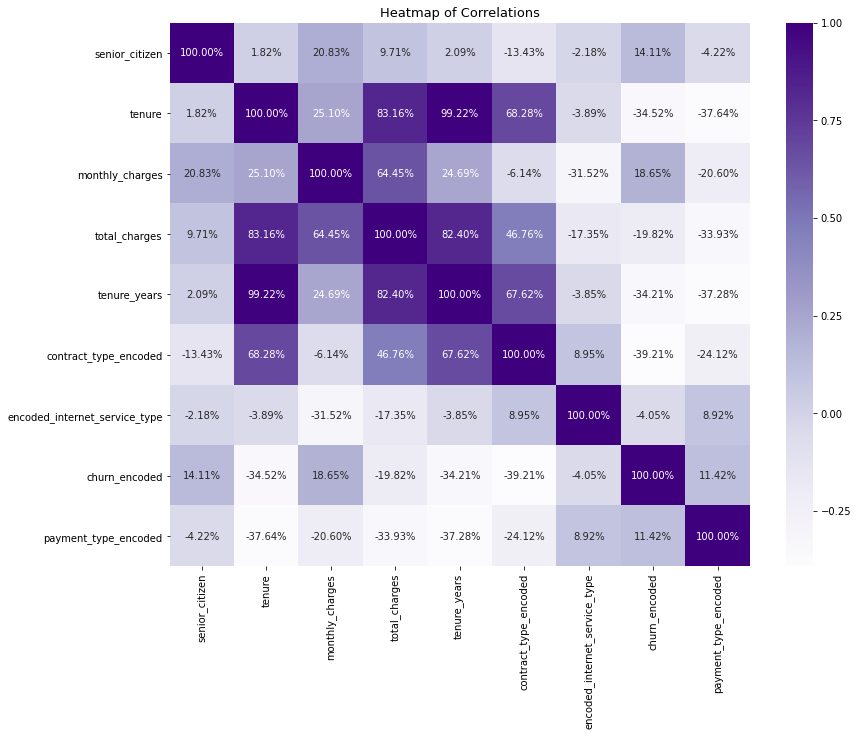

In [20]:
#take a look at correlations of numerical data
explore.corr_heatmap(train)

### Takeaways
- mean for tenure is roughly 2 and a half years
- our max tenure is sitting at 6 years
- contract type seems to be our best indicator of whether a customer will churn or not